# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyarrow==15.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 39.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 15.0.2 which is incompatible.


In [3]:
!pip install langchain-community langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.0/384.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.2/140.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [1]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt-get install poppler-utils -y

!pip install langchain unstructured[all-docs] pydantic lxml openai chromadb tiktoken opencv-python

import os
import uuid
import base64
import random
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever
from unstructured.documents.elements import NarrativeText, Image, Table

from pathlib import Path
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore

from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from operator import itemgetter
from langchain.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import ParentDocumentRetriever
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser


import matplotlib.pyplot as plt
import cv2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from operator import itemgetter
from langchain.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import ParentDocumentRetriever
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser
import random

In [3]:
from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')

# Preprocessing

In [4]:
# output_path = "./images"
proj_path = '/content/drive/MyDrive/NEU/LLM/Project'
pdfs_path = '/content/drive/MyDrive/NEU/LLM/Project/pdfs'

## Functions to extract Data

In [ ]:
text_summary_prompt = """
Summarize the following {element_type}:
{element}
"""

text_summary_chain = LLMChain(
    llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key = openai_api_key, max_tokens=1024),
    prompt=PromptTemplate.from_template(text_summary_prompt)
)


def extract_text_with_metadata(elements, source_document_path):
    text_data = []
    text_summaries = []
    text_contents = []
    paragraph_counters = {}

    for element in elements:
        if isinstance(element, NarrativeText) or 'CompositeElement' in repr(element) or "unstructured.documents.elements.NarrativeText" in str(type(element)):
            page_number = element.metadata.page_number

            if page_number not in paragraph_counters:
                paragraph_counters[page_number] = 1
            else:
                paragraph_counters[page_number] += 1

            paragraph_number = paragraph_counters[page_number]

            text_content = element.text

            summary = text_summary_chain.run({'element_type': 'text', 'element': text_content})

            text_data.append({
                "source_document": source_document_path,
                "page_number": page_number,
                "paragraph_number": paragraph_number,
                'type': 'text',
                "text": text_content
            })

            text_contents.append(text_content)
            text_summaries.append(summary)

    return text_contents, text_summaries, text_data

def extract_table_metadata_with_summary(elements, source_document_path):

    table_data = []
    table_summaries = []

    for element in elements:
        if isinstance(element, Table) or 'Table' in repr(element):
            page_number = element.metadata.page_number

            table_content = str(element)


            description = text_summary_chain.run({'element_type': 'table', 'element': table_content})

            table_data.append({
                "source_document": source_document_path,
                "page_number": page_number,
                "table_content": table_content,
                'type': 'table'
            })

            table_summaries.append(description)

    return table_summaries, table_data


def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')


def summarize_image(encoded_image):
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing historical images."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key, max_tokens=1024).invoke(prompt)
    return response.content

def extract_image_metadata_with_summary(elements, source_document_path):

    image_data = []
    image_summaries = []


    for element in elements:
        if "Image" in str(type(element)):
            page_number = element.metadata.page_number if hasattr(element.metadata, 'page_number') else None
            image_path = element.metadata.image_path if hasattr(element.metadata, 'image_path') else None

            if image_path and os.path.exists(image_path):

                encoded_image = encode_image(image_path)
                description = summarize_image(encoded_image)

                image_data.append({
                    "source_document": source_document_path,
                    "page_number": page_number,
                    "image_path": image_path,
                    "description": description,
                    'type': 'image'
                })

                image_summaries.append(description)
            else:
                print(f"Warning: Image file not found or path not available for image on page {page_number}")

    return image_summaries, image_data

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [20]:
def plot_images(image_folder=None, image_path_list=None):

  if image_folder:
    img_colors = [cv2.cvtColor(cv2.imread(image_folder + '/' + img_file, -1), cv2.COLOR_BGR2RGB) for img_file in os.listdir(image_folder)]

  if image_path_list:
    img_colors = [cv2.cvtColor(cv2.imread(image_path, -1), cv2.COLOR_BGR2RGB) for image_path in image_path_list]

  if len(image_path_list) > 0:
    fig, ax = plt.subplots(-(-len(img_colors)//2), 2, figsize=(8,-(-len(img_colors)//2) * 4))
    if len(img_colors)<3:
      for i, img in enumerate(img_colors):
        ax[i].axis('off')
        ax[i].imshow(img)
    else:
      for i, img in enumerate(img_colors):
        ax[i//2][i%2].axis('off')
        ax[i//2][i%2].imshow(img)

## Extract Data

#### Orig

In [ ]:
for filename in os.listdir(pdfs_path):
  print(filename)

great_fire_of_boston_1.pdf
boston_public_library_1.pdf
boston_marathon.pdf
paul_revere_1.pdf
old_south_church_2.pdf
old_north_church_1.pdf
freedom_trail_1.pdf
freedom_trail_2.pdf
paul_revere_house_1.pdf
bunker_hill_2.pdf
boston_massacre_1.pdf
faneuil_hall_2.pdf
old_south_meeting_house_1.pdf
boston_common_2.pdf
boston_tea_party_1.pdf


In [ ]:
# Extract the required data from parsed pdf
text_elements = []
text_contents = []
text_summaries = []
table_elements = []
table_summaries = []
image_elements = []
image_summaries = []

for filename in os.listdir(pdfs_path):
  path = os.path.join(pdfs_path, filename)
  filename_wo_extension = Path(path).stem
  print('-'*20, 'Processing', filename_wo_extension, '-'*20)

  raw_pdf_elements = partition_pdf(
    filename = path,
    strategy = "hi_res",
    extract_images_in_pdf = True,
    extract_image_block_types = ["Image", "Table"],
    extract_image_block_to_payload = False,
    extract_image_block_output_dir = proj_path + '/images/' + filename_wo_extension + '/'
  )

  print('-'*10, 'Text Processing', '-'*10)
  pdf_text_contents, pdf_text_summaries, pdf_text_data = extract_text_with_metadata(raw_pdf_elements, path)

  print('-'*10, 'Table Processing', '-'*10)
  pdf_table_summaries, pdf_table_data = extract_table_metadata_with_summary(raw_pdf_elements, path)

  print('-'*10, 'Image Processing', '-'*10)
  pdf_image_summaries, pdf_image_data = extract_image_metadata_with_summary(raw_pdf_elements, path)


  text_elements.extend(pdf_text_data)
  text_contents.extend(pdf_text_contents)
  text_summaries.extend(pdf_text_summaries)
  table_elements.extend(pdf_table_data)
  table_summaries.extend(pdf_table_summaries)
  image_elements.extend(pdf_image_data)
  image_summaries.extend(pdf_image_summaries)

-------------------- Processing great_fire_of_boston_1 --------------------


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

---------- Text Processing ----------


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


---------- Table Processing ----------
---------- Image Processing ----------
-------------------- Processing boston_public_library_1 --------------------
---------- Text Processing ----------
---------- Table Processing ----------
---------- Image Processing ----------
-------------------- Processing boston_marathon --------------------
---------- Text Processing ----------
---------- Table Processing ----------
---------- Image Processing ----------
-------------------- Processing paul_revere_1 --------------------
---------- Text Processing ----------
---------- Table Processing ----------
---------- Image Processing ----------
-------------------- Processing old_south_church_2 --------------------
---------- Text Processing ----------
---------- Table Processing ----------
---------- Image Processing ----------
-------------------- Processing old_north_church_1 --------------------
---------- Text Processing ----------
---------- Table Processing ----------
---------- Image Process

* text_elements = list of text metadata (dict)
* text_contents = list of text
* text_summaries = list of text summaries
* table_elements = list of table metadata (dict)
* table_summaries = list of table summaries
* image_elements = list of image metadata (dict)
* image_summaries = list of image summaries


In [ ]:
# text_elements, text_contents, text_summaries, table_elements, table_summaries, image_elements, image_summaries
print( '-'*25, 'text_elements', '-'*25)
print('Length: ', len(text_elements))
print(text_elements[0])
print( '-'*25, 'text_contents', '-'*25)
print('Length: ', len(text_contents))
print(text_contents[0])
print( '-'*25, 'text_summaries', '-'*25)
print('Length: ', len(text_summaries))
print(text_summaries[0])
print( '-'*25, 'table_elements', '-'*25)
print('Length: ', len(table_elements))
print(table_elements[0])
print( '-'*25, 'table_summaries', '-'*25)
print('Length: ', len(table_summaries))
print(table_summaries[0])
print( '-'*25, 'image_elements', '-'*25)
print('Length: ', len(image_elements))
print(image_elements[0])
print( '-'*25, 'image_summaries', '-'*25)
print('Length: ', len(image_summaries))
print(image_summaries[0])

------------------------- text_elements -------------------------
Length:  372
{'source_document': '/content/drive/MyDrive/NEU/LLM/Project/pdfs/great_fire_of_boston_1.pdf', 'page_number': 1, 'paragraph_number': 1, 'type': 'text', 'text': 'by EileenS November 7, 2019'}
------------------------- text_contents -------------------------
Length:  372
by EileenS November 7, 2019
------------------------- text_summaries -------------------------
Length:  372
The text is about an event or topic discussed by EileenS on November 7, 2019.
------------------------- table_elements -------------------------
Length:  14
{'source_document': '/content/drive/MyDrive/NEU/LLM/Project/pdfs/boston_marathon.pdf', 'page_number': 3, 'table_content': 'year men* 1897 John J. McDermott 1898 Ronald J. MacDonald (Can.) 1899 Lawrence J. Brignolia 1900 John J. Caffery (Can.) 1901 John J. Caffery (Can.) 1902 Sammy Mellor 1903 John Lorden 1904 Michael Spring 1905 Frederick Lorz 1906 Tim Ford 1907 Tim Longboat (Can.) 19

### Pickle lists

In [5]:
import pickle

In [ ]:
with open('text_elements.pkl', 'wb') as f:
  pickle.dump(text_elements, f)

with open('text_contents.pkl', 'wb') as f:
  pickle.dump(text_contents, f)

with open('text_summaries.pkl', 'wb') as f:
  pickle.dump(text_summaries, f)

with open('table_elements.pkl', 'wb') as f:
  pickle.dump(table_elements, f)

with open('table_summaries.pkl', 'wb') as f:
  pickle.dump(table_summaries, f)

with open('image_elements.pkl', 'wb') as f:
  pickle.dump(image_elements, f)

with open('image_summaries.pkl', 'wb') as f:
  pickle.dump(image_summaries, f)

In [6]:
text_elements = []
text_contents = []
text_summaries = []
table_elements = []
table_summaries = []
image_elements = []
image_summaries = []

with open('text_elements.pkl', 'rb') as f:
  text_elements = pickle.load(f)

with open('text_contents.pkl', 'rb') as f:
  text_contents = pickle.load(f)

with open('text_summaries.pkl', 'rb') as f:
  text_summaries = pickle.load(f)

with open('table_elements.pkl', 'rb') as f:
  table_elements = pickle.load(f)

with open('table_summaries.pkl', 'rb') as f:
  table_summaries = pickle.load(f)

with open('image_elements.pkl', 'rb') as f:
  image_elements = pickle.load(f)

with open('image_summaries.pkl', 'rb') as f:
  image_summaries = pickle.load(f)

In [8]:
print( '-'*25, 'text_elements', '-'*25)
print('Length: ', len(text_elements))
print(text_elements[0])
print( '-'*25, 'text_contents', '-'*25)
print('Length: ', len(text_contents))
print(text_contents[0])
print( '-'*25, 'text_summaries', '-'*25)
print('Length: ', len(text_summaries))
print(text_summaries[0])
print( '-'*25, 'table_elements', '-'*25)
print('Length: ', len(table_elements))
print(table_elements[0])
print( '-'*25, 'table_summaries', '-'*25)
print('Length: ', len(table_summaries))
print(table_summaries[0])
print( '-'*25, 'image_elements', '-'*25)
print('Length: ', len(image_elements))
print(image_elements[0])
print( '-'*25, 'image_summaries', '-'*25)
print('Length: ', len(image_summaries))
print(image_summaries[0])

------------------------- text_elements -------------------------
Length:  372
{'source_document': '/content/drive/MyDrive/NEU/LLM/Project/pdfs/great_fire_of_boston_1.pdf', 'page_number': 1, 'paragraph_number': 1, 'type': 'text', 'text': 'by EileenS November 7, 2019'}
------------------------- text_contents -------------------------
Length:  372
by EileenS November 7, 2019
------------------------- text_summaries -------------------------
Length:  372
The text is about an event or topic discussed by EileenS on November 7, 2019.
------------------------- table_elements -------------------------
Length:  14
{'source_document': '/content/drive/MyDrive/NEU/LLM/Project/pdfs/boston_marathon.pdf', 'page_number': 3, 'table_content': 'year men* 1897 John J. McDermott 1898 Ronald J. MacDonald (Can.) 1899 Lawrence J. Brignolia 1900 John J. Caffery (Can.) 1901 John J. Caffery (Can.) 1902 Sammy Mellor 1903 John Lorden 1904 Michael Spring 1905 Frederick Lorz 1906 Tim Ford 1907 Tim Longboat (Can.) 19

## Making Documents

In [9]:
id_key = "doc_id"

# Add text
text_ids = [str(uuid.uuid4()) for _ in text_elements]

# Used for Parent-Child, Ensemble

text_content_docs = [
    Document(page_content=s, metadata={id_key: text_ids[i]})
    for i, s in enumerate(text_contents)
]

# Used for Retreival using Summary
text_summary_docs = [
    Document(page_content=s, metadata={id_key: text_ids[i]})
    for i, s in enumerate(text_summaries)
]


# Add tables
table_ids = [str(uuid.uuid4()) for _ in table_elements]
table_summary_docs = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]


# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in image_elements]
img_summary_docs = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(image_summaries)
]


In [10]:
def add_docs_to_retriever(retriever, text_docs):
  retriever.vectorstore.add_documents(text_docs)
  retriever.docstore.mset(list(zip(text_ids, text_elements)))

  retriever.vectorstore.add_documents(table_summary_docs)
  retriever.docstore.mset(list(zip(table_ids, table_elements)))

  retriever.vectorstore.add_documents(img_summary_docs)
  retriever.docstore.mset(list(zip(img_ids, image_elements)))

# Retrieval

## Retrieval Functions

In [11]:
def make_docs():
  context_docs = []

  for d in text_elements:
    context_docs.append(Document(page_content = d['text'], metadata={'type': d['type']}))

  for summ, elem in zip(table_summaries, table_elements):
    context_docs.append(Document(page_content = summ, metadata={'type': elem['type'], 'table_content': elem['table_content']}))

  for d in image_elements:
    context_docs.append(Document(page_content = d['description'], metadata={'type': d['type'], 'image_path': d['image_path']}))

  return context_docs


In [12]:
def get_context_contents(retrieved_docs):
  context_docs = []

  if len(retrieved_docs)>0 and type(retrieved_docs[0]) == Document:
    return retrieved_docs

  for d in retrieved_docs:
    # if type(d) == dict:
      if d['type'] == 'text':
        context_docs.append(Document(page_content = d['text'], metadata={'type': d['type']}))
      elif d['type'] == 'table':
        context_docs.append(Document(page_content = d['table_content'], metadata={'type': d['type']}))
      elif d['type'] == 'image':
        context_docs.append(Document(page_content = d['description'], metadata={'type': d['type'], 'image_path': d['image_path']}))



  return context_docs

def make_prompt(data_dict):
    """
    Join the context into a single string
    """

    formatted_texts = ""
    for doc in data_dict["context"]:
      formatted_texts = formatted_texts + "\n" + doc.page_content
    messages = []

    text_message = {
        "type": "text",
        "text": (
            "You are an assistant that answers questions about history of Boston.\n"
            "You will be given a mixed info(s) .\n"
            "Use this information to provide relevant information to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables and / or image summaries:"
            f"{formatted_texts}"
        ),
    }
    messages = [text_message]
    return [HumanMessage(content=messages)]

def create_qa_chain(retriever):


  primary_qa_llm = ChatOpenAI(model_name="gpt-3.5-turbo", openai_api_key = openai_api_key)

  created_qa_chain = (
    {"context": itemgetter("question") | retriever | RunnableLambda(get_context_contents), "question": itemgetter("question")}

    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": RunnableLambda(make_prompt) | primary_qa_llm, "context": itemgetter("context")}
  )

  return created_qa_chain

In [15]:
def get_chain(retr_type='summary', k=4, docs=None, bm25_k=2, hybrid_weights = [0.75, 0.25]):
  vectorstore = Chroma(collection_name=f"{retr_type}_retrieval", embedding_function=OpenAIEmbeddings(openai_api_key=openai_api_key))

  # The storage layer for the parent documents
  store = InMemoryStore()
  id_key = "doc_id"

  if retr_type == 'summary':
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )
    retriever.search_kwargs['k'] = k
    add_docs_to_retriever(retriever, text_summary_docs)

  elif retr_type == 'parent_child':
    child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)
    retriever = ParentDocumentRetriever(
      vectorstore = vectorstore,
      docstore = store,
      child_splitter = child_splitter,
    )
    retriever.search_kwargs['k'] = k
    add_docs_to_retriever(retriever, text_content_docs)

  else:
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=450, chunk_overlap=75)
    hybrid_docs = text_splitter.split_documents(docs)

    bm25_retriever = BM25Retriever.from_documents(hybrid_docs)
    bm25_retriever.k = bm25_k

    vectorstore = Chroma.from_documents(hybrid_docs, collection_name="hybrid_retrieval", embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))

    chroma_retriever = vectorstore.as_retriever(search_kwargs={"k": k})

    retriever = EnsembleRetriever(retrievers=[bm25_retriever, chroma_retriever], weights=hybrid_weights)


  qa_chain = create_qa_chain(retriever)

  return qa_chain

In [14]:
def print_qa_result(result):
  print('Response:')
  print(result['response'].content)


  retreived_images = []
  for doc in result['context']:
    if doc.metadata['type'] == 'image':
      retreived_images.append(doc.metadata['image_path'])

  plot_images(image_path_list = retreived_images)

In [146]:
def plot_only_images(result):
  retreived_images = []
  for doc in result['context']:
    if doc.metadata['type'] == 'image':
      retreived_images.append(doc.metadata['image_path'])

  plot_images(image_path_list = retreived_images)

## Retrieval using Summary

In [ ]:
# The vectorstore to use to index the child chunks
persist_directory_1 = 'db_1'
vectorstore_1 = Chroma(collection_name="summary_retrieval", embedding_function=OpenAIEmbeddings(openai_api_key=openai_api_key), persist_directory = persist_directory_1)


# The storage layer for the parent documents
store_1 = InMemoryStore()
id_key_1 = "doc_id"

# The retriever (empty to start)
retriever_1 = MultiVectorRetriever(
    vectorstore=vectorstore_1,
    docstore=store_1,
    id_key=id_key_1,
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 0.4. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  warn_deprecated(


In [ ]:
add_docs_to_retriever(retriever_1, text_summary_docs)

In [ ]:
# tmp_retr = retriever_1.get_relevant_documents('Give information about Boston Tea Party?')

In [ ]:
summary_qa_chain = create_qa_chain(retriever_1)

In [ ]:
summary_res = summary_qa_chain.invoke({"question" : 'Give information about Boston Tea Party?'})

In [ ]:
summary_res['response'].content

'The Boston Tea Party was a key event in the lead-up to the American Revolution. It took place on December 16, 1773, when a group of colonists, some disguised as Native Americans, boarded British ships in Boston Harbor and dumped 342 crates of tea into the water as a protest against British taxation without representation. This act of defiance was organized by Samuel Adams and the Sons of Liberty, with signals given from the Old South Meeting House. The event was condemned by Governor Thomas Hutchinson as an act of treason, leading to further tensions between the colonies and Britain. The aftermath of the Boston Tea Party included the passage of the Coercive Acts by Parliament, also known as the Intolerable Acts, which aimed to punish the colonies, especially New England. Despite differing opinions among colonial leaders like Benjamin Franklin and George Washington, the Boston Tea Party remains a symbol of colonial resistance against British oppression.'

Response:
The Boston Tea Party was a key event in the lead-up to the American Revolution. It took place on December 16, 1773, when a group of colonists, some disguised as Native Americans, boarded British ships in Boston Harbor and dumped 342 crates of tea into the water as a protest against British taxation without representation. This act of defiance was organized by Samuel Adams and the Sons of Liberty, with signals given from the Old South Meeting House. The event was condemned by Governor Thomas Hutchinson as an act of treason, leading to further tensions between the colonies and Britain. The aftermath of the Boston Tea Party included the passage of the Coercive Acts by Parliament, also known as the Intolerable Acts, which aimed to punish the colonies, especially New England. Despite differing opinions among colonial leaders like Benjamin Franklin and George Washington, the Boston Tea Party remains a symbol of colonial resistance against British oppression.


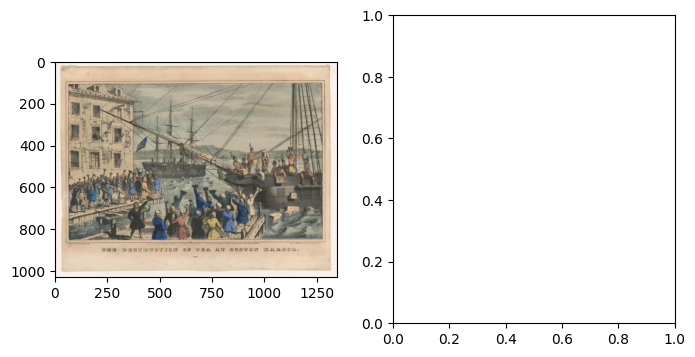

In [ ]:
print_qa_result(summary_res)

In [17]:
summary_qa_4_chain = get_chain('summary', k=4)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [18]:
summary_res = summary_qa_4_chain.invoke({"question" : 'Give information about Boston Tea Party?'})
summary_res['response'].content

'The Boston Tea Party was a pivotal event in American history that took place on December 16, 1773, when a group of colonists, disguised as Native Americans, boarded British ships in Boston Harbor and dumped 342 crates of tea into the water as a protest against British taxation without representation. This act of defiance was organized by the Sons of Liberty and led by figures like Samuel Adams, who played a key role in publicizing the event as a defense of colonial rights. While some colonial leaders like John Adams praised the Tea Party as a brave assertion of popular power, others like Benjamin Franklin and George Washington disapproved, believing it to be an overstep. The British government responded harshly with the Coercive Acts, also known as the Intolerable Acts, which aimed to punish the colonies, particularly New England, by closing Boston Harbor, restricting free elections, and imposing martial law. This event was a significant step towards the American Revolution and indepe

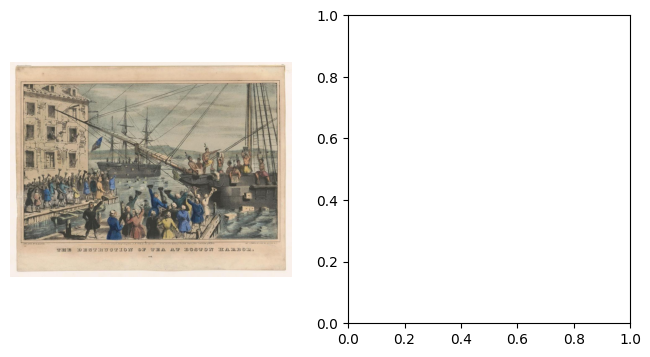

In [147]:
plot_only_images(summary_res)

Response:
The Boston Tea Party was a pivotal event in American history that took place on December 16, 1773, when a group of colonists, disguised as Native Americans, boarded British ships in Boston Harbor and dumped 342 crates of tea into the water as a protest against British taxation without representation. This act of defiance was organized by the Sons of Liberty and led by figures like Samuel Adams, who played a key role in publicizing the event as a defense of colonial rights. While some colonial leaders like John Adams praised the Tea Party as a brave assertion of popular power, others like Benjamin Franklin and George Washington disapproved, believing it to be an overstep. The British government responded harshly with the Coercive Acts, also known as the Intolerable Acts, which aimed to punish the colonies, particularly New England, by closing Boston Harbor, restricting free elections, and imposing martial law. This event was a significant step towards the American Revolution a

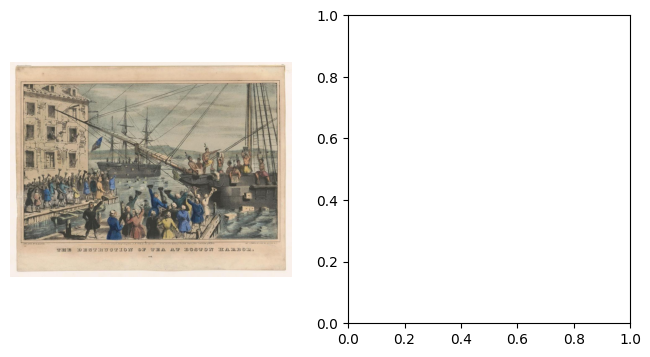

In [21]:
print_qa_result(summary_res)

### K= 3, 5, 6

In [23]:
summary_qa_3_chain = get_chain('summary', k=3)
summary_qa_5_chain = get_chain('summary', k=5)
summary_qa_6_chain = get_chain('summary', k=6)

## Parent Child Retreiver

In [ ]:
# This text splitter is used to create the child documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

persist_directory_2 = 'db_2'
# The vectorstore to use to index the child chunks
vectorstore_2 = Chroma(collection_name="parent_child_retrieval", embedding_function=OpenAIEmbeddings(openai_api_key=openai_api_key), persist_directory = persist_directory_2)

# The storage layer for the parent documents
store_2 = InMemoryStore()

parent_child_retriever = ParentDocumentRetriever(
    vectorstore = vectorstore_2,
    docstore = store_2,
    child_splitter = child_splitter,
)

In [ ]:
add_docs_to_retriever(parent_child_retriever, text_content_docs)

In [ ]:
parent_child_qa_chain = create_qa_chain(parent_child_retriever)

In [ ]:
pc_1 = parent_child_qa_chain.invoke({"question" : 'Give information about Boston Tea Party?'})

In [ ]:
pc_1

{'response': AIMessage(content='The Boston Tea Party was a pivotal event in the lead-up to the American Revolution. It took place on December 16, 1773, when a group of colonists, some disguised as Native Americans, boarded three British ships in Boston Harbor and dumped 342 chests of tea into the water as a protest against British taxation without representation. This act of defiance was organized by figures like Samuel Adams, who gave signals from the Old South Meeting House to initiate the protest. The Boston Tea Party was a significant moment of resistance against British authority and played a crucial role in the push towards American independence.', response_metadata={'token_usage': {'completion_tokens': 119, 'prompt_tokens': 367, 'total_tokens': 486}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-15bd8978-c534-4d9c-b27b-1d4ade04d655-0'),
 'context': [Document(metadata={'type': 'image', 'image_path': '/content/drive/

Response:
The Boston Tea Party was a pivotal event in the lead-up to the American Revolution. It took place on December 16, 1773, when a group of colonists, some disguised as Native Americans, boarded three British ships in Boston Harbor and dumped 342 chests of tea into the water as a protest against British taxation without representation. This act of defiance was organized by figures like Samuel Adams, who gave signals from the Old South Meeting House to initiate the protest. The Boston Tea Party was a significant moment of resistance against British authority and played a crucial role in the push towards American independence.


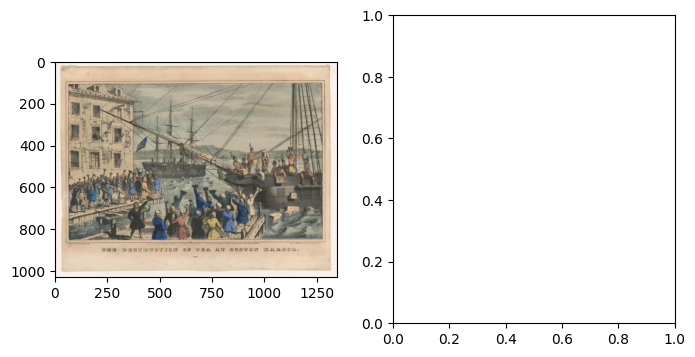

In [ ]:
print_qa_result(pc_1)

In [24]:
parent_child_qa_4_chain = get_chain('parent_child', k=4)

In [26]:
pc_1 = parent_child_qa_4_chain.invoke({"question" : 'Give information about Boston Tea Party?'})
pc_1

{'response': AIMessage(content="The Boston Tea Party was a significant event in American history that took place on December 16, 1773. It was a protest against the British government's imposition of taxes on the American colonies without representation. The event was organized by the Sons of Liberty, led by figures such as Samuel Adams. Disguised as Native Americans, a group of colonists boarded three British ships in Boston Harbor and dumped 342 chests of tea into the water as a protest against the Tea Act of 1773. This act of defiance played a crucial role in escalating tensions between the American colonists and the British government, ultimately leading to the American Revolution. The Boston Tea Party is considered a symbol of resistance and the fight for independence.", response_metadata={'token_usage': {'completion_tokens': 145, 'prompt_tokens': 367, 'total_tokens': 512}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='ru

Response:
The Boston Tea Party was a significant event in American history that took place on December 16, 1773. It was a protest against the British government's imposition of taxes on the American colonies without representation. The event was organized by the Sons of Liberty, led by figures such as Samuel Adams. Disguised as Native Americans, a group of colonists boarded three British ships in Boston Harbor and dumped 342 chests of tea into the water as a protest against the Tea Act of 1773. This act of defiance played a crucial role in escalating tensions between the American colonists and the British government, ultimately leading to the American Revolution. The Boston Tea Party is considered a symbol of resistance and the fight for independence.


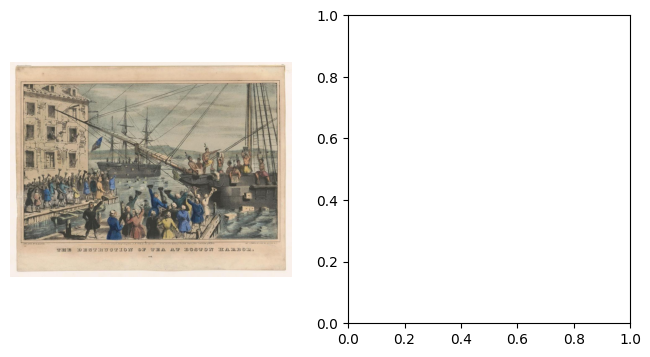

In [27]:
print_qa_result(pc_1)

### K = 3,5,6

In [30]:
parent_child_qa_3_chain = get_chain('parent_child', k=3)
parent_child_qa_5_chain = get_chain('parent_child', k=5)
parent_child_qa_6_chain = get_chain('parent_child', k=6)

## Hybrid Retriever

In [28]:
!pip install rank_bm25

In [29]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [31]:
docs = make_docs()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=450, chunk_overlap=75)
hybrid_docs = text_splitter.split_documents(docs)

bm25_retriever = BM25Retriever.from_documents(hybrid_docs)
bm25_retriever.k = 2

persist_directory_3 = 'db_3'
vectorstore_3 = Chroma.from_documents(hybrid_docs, collection_name="hybrid_retrieval", embedding=OpenAIEmbeddings(openai_api_key=openai_api_key), persist_directory = persist_directory_3)

chroma_retriever = vectorstore_3.as_retriever(search_kwargs={"k": 3})

ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, chroma_retriever], weights=[0.75, 0.25])

In [ ]:
hybrid_qa_chain = create_qa_chain(ensemble_retriever)

In [ ]:
tmp_res_3 = hybrid_qa_chain.invoke({"question" : 'Give information about Boston Tea Party?'})

Response:
The Boston Tea Party was a significant event that took place on December 16, 1773. It was a protest by American colonists against British taxation, specifically the Tea Act of 1773. A group of individuals, some disguised as Native Americans, boarded British ships in Boston Harbor and dumped crates of tea into the water. This act of defiance was a key moment in the lead-up to the American Revolution. Samuel Adams played a prominent role in organizing the event, giving signals from the Old South Meeting House that sparked the protest. Paul Revere, known for his role as a Son of Liberty and member of the North End Caucus, also played a part in spreading news of the Boston Tea Party to other colonies. The event symbolized the colonists' resistance to British control and paved the way for further acts of rebellion against British rule.


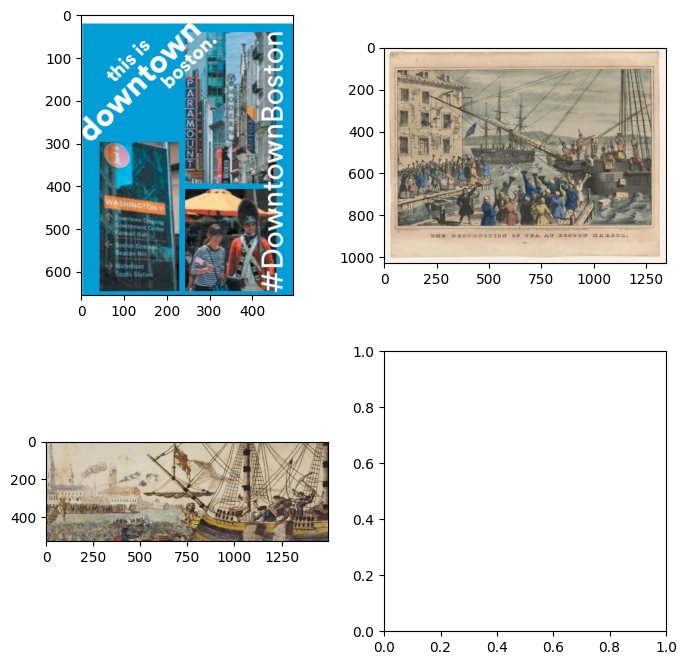

In [ ]:
print_qa_result(tmp_res_3)

Response:
The Boston Tea Party was a significant event that took place on December 16, 1773, where colonists disguised as Native Americans boarded British ships and dumped chests of tea into Boston Harbor as a protest against the Tea Act. This act of defiance was a key event leading up to the American Revolution.

If you are interested in exploring more historical sites in Boston, you may want to check out the Freedom Trail. Established in 1951, this 2.5 mile trail features 17 historical sites and is a great way to learn about the history of Boston. The trail is easy to navigate and follows a brick surface, making it ideal for walking and exploring. For more information, you can visit www.thefreedomtrail.org.


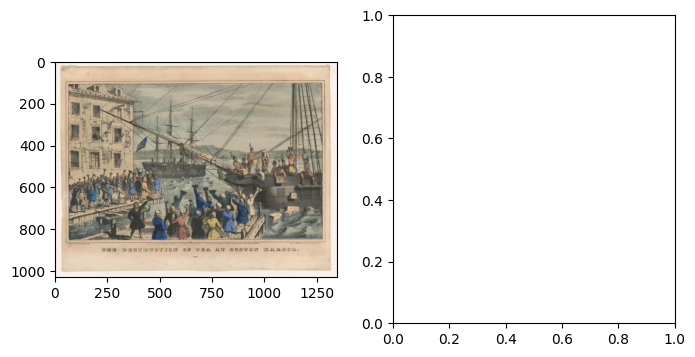

In [ ]:
print_qa_result(tmp_res_3)

In [32]:
hybrid_qa_3_2_chain = get_chain('hybrid', k=3, docs=docs, bm25_k=2)

In [33]:
hybrid_qa_4_2_chain = get_chain('hybrid', k=4, docs=docs, bm25_k=2)
hybrid_qa_5_2_chain = get_chain('hybrid', k=5, docs=docs, bm25_k=2)

hybrid_qa_3_3_chain = get_chain('hybrid', k=3, docs=docs, bm25_k=3)
hybrid_qa_4_3_chain = get_chain('hybrid', k=4, docs=docs, bm25_k=3)
hybrid_qa_5_3_chain = get_chain('hybrid', k=5, docs=docs, bm25_k=3)

hybrid_qa_3_4_chain = get_chain('hybrid', k=3, docs=docs, bm25_k=4)
hybrid_qa_4_4_chain = get_chain('hybrid', k=4, docs=docs, bm25_k=4)
hybrid_qa_5_4_chain = get_chain('hybrid', k=5, docs=docs, bm25_k=4)

## Qualitative Comparisons

### Ques 1: Describe the Tea Act.

In [ ]:
ques_1 = 'Describe the Tea Act.'

In [ ]:
q1_summ_res = summary_qa_chain.invoke({"question" : ques_1})
q1_pc_res = parent_child_qa_chain.invoke({"question" : ques_1})
q1_hybrid_res = hybrid_qa_chain.invoke({"question" : ques_1})

In [ ]:
print_qa_result(q1_summ_res)

Response:
The Tea Act was introduced by Great Britain on May 10, 1773 with the goal of asserting the authority of the American colonies and supporting the struggling East India Company. The act allowed the company to sell tea directly to colonists, bypassing middlemen and reducing costs. However, this move outraged many colonists who saw it as a threat to their rights and a sign of British and East India Company's growing control over the colonies. The Tea Act ultimately led to events like the Boston Tea Party, where colonists protested against the act by throwing tea into the harbor.


In [ ]:
print_qa_result(q1_pc_res)

Response:
The Tea Act was a legislation passed by the British Parliament in 1773 that granted the East India Company the exclusive right to sell tea directly to the American colonies, bypassing the usual merchants and middlemen. This allowed the company to reduce costs and sell their tea at a lower price. However, the act was met with strong opposition from colonists who saw it as a threat to their rights and freedoms, fearing it could set a dangerous precedent of British and East India Company authority over the colonies. The act ultimately led to the Boston Tea Party on December 16, 1773, where a group of colonists disguised as Native Americans boarded British ships and dumped 342 crates of tea into Boston Harbor in protest of the Tea Act. This event further escalated tensions between the colonies and Britain, ultimately leading to the passage of the Coercive Acts, also known as the Intolerable Acts, in response to the Boston Tea Party.


In [ ]:
print_qa_result(q1_hybrid_res)

Response:
The Tea Act was introduced by Great Britain on May 10, 1773 in an attempt to reassert its authority over the American colonies and help the struggling East India Company. The act allowed the company to sell tea directly to colonists, bypassing middlemen and lowering costs. This move angered colonists, who saw it as a way for Britain to exert control over them. In response, the Boston Tea Party occurred on December 16, 1773, where colonists disguised as Native Americans boarded British ships and dumped chests of tea into the Boston Harbor as a protest against the Tea Act.


### Ques 2: What is the length of freedom trail and what is its surface made up of?

In [ ]:
ques_2 = 'What is the length of freedom trail and what is its surface made up of?'

In [ ]:
q2_summ_res = summary_qa_chain.invoke({"question" : ques_2})
q2_pc_res = parent_child_qa_chain.invoke({"question" : ques_2})
q2_hybrid_res = hybrid_qa_chain.invoke({"question" : ques_2})

In [ ]:
print_qa_result(q2_summ_res)

Response:
The Freedom Trail in Boston is 2.5 miles long (4.0 km) and its surface is made up of brick. This trail connects 17 historical sites in Boston, from Boston Common to Bunker Hill Monument in Charlestown. It is a walking trail that is easy to navigate and follow, marked by special markers implanted in the sidewalk.


In [ ]:
print_qa_result(q2_pc_res)

Response:
The Freedom Trail in Boston is 2.5 miles long and its surface is made up of brick. The trail passes by 16 locations significant to the history of the United States, including Boston Common, the Old North Church, and the Bunker Hill Monument. Special markers implanted in the sidewalk denote the stops along the trail, making it easy to follow and explore the historical sites along the way.


Response:
The Freedom Trail in Boston is 2.5 miles long and its surface is made up of bricks. The trail passes by 16 locations significant to the history of the United States, including Boston Common, the Old North Church, and the Bunker Hill Monument. The trail was established in 1951 and is designated as a National Millennium Trail, meant for walking and exploring history. You can find more information on the official website www.thefreedomtrail.org.


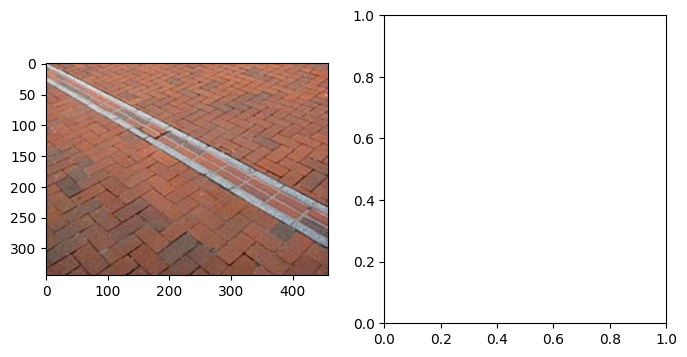

In [ ]:
print_qa_result(q2_hybrid_res)

### Ques 3: What was Faneuil Hall used for in past and present?

In [ ]:
ques_3 = 'What was Faneuil Hall used for in past and present?'

In [ ]:
q3_summ_res = summary_qa_chain.invoke({"question" : ques_3})
q3_pc_res = parent_child_qa_chain.invoke({"question" : ques_3})
q3_hybrid_res = hybrid_qa_chain.invoke({"question" : ques_3})

In [ ]:
print_qa_result(q3_summ_res)

Response:
Faneuil Hall was originally used as a public meeting venue where the citizens of Boston could gather to discuss and protest against Royal oppression. It also served as a marketplace for local townspeople to sell their goods. Today, Faneuil Hall is still used as a meeting place for debates and discussions on important issues, as well as hosting naturalization ceremonies in the Great Hall on the second floor. The National Park Service operates a visitor's center on the first floor, offering tours, free maps of the Freedom Trail, and books about Boston and United States history.


In [ ]:
print_qa_result(q3_pc_res)

Response:
Faneuil Hall was originally used as a marketplace for local townspeople to sell their goods in the past. It also served as a public meeting venue where citizens of Boston proclaimed their dissent against Royal oppression. Today, Faneuil Hall is used as a visitor center by the National Park Service, offering tours, free maps of the Freedom Trail, and books about Boston and United States history. Additionally, the City of Boston holds naturalization ceremonies in the Great Hall on the second floor.


In [ ]:
print_qa_result(q3_hybrid_res)

Response:
Faneuil Hall was originally used as a marketplace for local townspeople to sell their goods. However, it also served as a public meeting venue where citizens of Boston proclaimed their dissent against Royal oppression. Today, Faneuil Hall is still used as a meeting place and marketplace, but it also houses the Faneuil Hall Visitor Center operated by Boston National Historical Park. Additionally, the City of Boston holds naturalization ceremonies in the Great Hall on the second floor, continuing the tradition of important events taking place in this historic building.


# Evaluation

## Create Ground Truth Dataset

In [34]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

question_schema = ResponseSchema(
    name="question",
    description="a question about the context."
)

question_response_schemas = [
    question_schema,
]

In [35]:
question_output_parser = StructuredOutputParser.from_response_schemas(question_response_schemas)
format_instructions = question_output_parser.get_format_instructions()

In [36]:
question_generation_llm = ChatOpenAI(model="gpt-3.5-turbo-16k", openai_api_key = openai_api_key)

bare_prompt_template = "{content}"
bare_template = ChatPromptTemplate.from_template(template=bare_prompt_template)

In [37]:
docs[0]

Document(metadata={'type': 'text'}, page_content='by EileenS November 7, 2019')

In [38]:
eval_indices = random.sample(range(0, len(docs)), 25)

In [39]:
eval_docs = [docs[i] for i in eval_indices]

In [40]:
len(eval_docs)

25

In [41]:
from tqdm import tqdm

qa_template = """\
You are a bot creating a test in boston history. For each context, create one question that is specific to the context. Avoid creating generic or general questions.

question: a question about the context.

Format the output as JSON with the following keys:
question

context: {context}
"""

prompt_template = ChatPromptTemplate.from_template(template=qa_template)
question_generation_chain = bare_template | question_generation_llm

qac_triples = []

for text in tqdm(eval_docs):
  messages = prompt_template.format_messages(
      context=text,
      format_instructions=format_instructions
  )
  response = question_generation_chain.invoke({"content" : messages})
  try:
    output_dict = question_output_parser.parse(response.content)
  except Exception as e:
    continue
  output_dict["context"] = text
  qac_triples.append(output_dict)

100%|██████████| 25/25 [00:19<00:00,  1.27it/s]


In [45]:
qac_triples[22]

{'question': 'What role did Paul Revere play in the American Revolution?',
 'context': Document(metadata={'type': 'text'}, page_content='In February 1770, Revere bought a home in North Square in the North End (https://www.paulreverehouse.org/). As a Son of Liberty and member of the North End Caucus, Revere engraved political cartoons and helped plan and implement resistance to 9 British policies. His career as a "Messenger of the American Revolution" began on December 17, 1773, carrying news of the Boston Tea Party to New York. Thereafter, he regularly relayed information between the Boston Committee of Correspondence and the Continental Congress in Philadelphia. 10')}

In [47]:
answer_generation_llm = ChatOpenAI(model="gpt-4-1106-preview", temperature=0, openai_api_key = openai_api_key)

answer_schema = ResponseSchema(
    name="answer",
    description="an answer to the question"
)

answer_response_schemas = [
    answer_schema,
]

answer_output_parser = StructuredOutputParser.from_response_schemas(answer_response_schemas)
format_instructions = answer_output_parser.get_format_instructions()

qa_template = """\
You are a bot creating a test in boston history. For each question and context, create an answer.

answer: a answer about the context.

Format the output as JSON with the following keys:
answer

question: {question}
context: {context}
"""

prompt_template = ChatPromptTemplate.from_template(template=qa_template)

answer_generation_chain = bare_template | answer_generation_llm

for triple in tqdm(qac_triples):
  messages = prompt_template.format_messages(
      context=triple["context"],
      question=triple["question"],
      format_instructions=format_instructions
  )
  response = answer_generation_chain.invoke({"content" : messages})
  try:
    output_dict = answer_output_parser.parse(response.content)
  except Exception as e:
    continue
  triple["answer"] = output_dict["answer"]

100%|██████████| 23/23 [01:26<00:00,  3.78s/it]


In [ ]:
# !pip uninstall pyarrow

Found existing installation: pyarrow 17.0.0
Uninstalling pyarrow-17.0.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/benchmarks/*
    /usr/local/lib/python3.10/dist-packages/cmake_modules/AWSSDKVariables.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/BuildUtils.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/DefineOptions.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindAWSSDKAlt.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindAzure.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindBrotliAlt.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindClangTools.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindGTestAlt.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindInferTools.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindLLVMAlt.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindOpenSSLAlt.cmake
 

In [ ]:
# !pip install pyarrow==15.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 23.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 15.0.2 which is incompatible.


In [50]:
!pip install -q -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 15.0.2 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which is incompatible.


In [51]:
import pandas as pd
from datasets import Dataset

ground_truth_qac_set = pd.DataFrame(qac_triples)
ground_truth_qac_set["context"] = ground_truth_qac_set["context"].map(lambda x: str(x.page_content))
ground_truth_qac_set = ground_truth_qac_set.rename(columns={"answer" : "ground_truth"})


eval_dataset = Dataset.from_pandas(ground_truth_qac_set)

In [53]:
eval_dataset.to_csv("groundtruth_eval_dataset.csv")

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

19585

## Ragas

In [54]:
!pip install ragas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.2 MB/s eta 0:00:00


In [55]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    answer_correctness,
    answer_similarity
)

from ragas.metrics.critique import harmfulness
from ragas import evaluate

def create_ragas_dataset(rag_pipeline, eval_dataset):
  rag_dataset = []
  for row in tqdm(eval_dataset):
    answer = rag_pipeline.invoke({"question" : row["question"]})
    rag_dataset.append(
        {"question" : row["question"],
         "answer" : answer["response"].content,
         "contexts" : [context.page_content for context in answer["context"]],
         "ground_truths" : [row["ground_truth"]]
         }
    )
  rag_df = pd.DataFrame(rag_dataset)
  rag_eval_dataset = Dataset.from_pandas(rag_df)
  return rag_eval_dataset

os.environ["OPENAI_API_KEY"] = openai_api_key

def evaluate_ragas_dataset(ragas_dataset):
  result = evaluate(
    ragas_dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
        answer_correctness,
        answer_similarity
    ],
  )
  return result

## Summary QA Chain

In [56]:
summary_qa_chains = [summary_qa_3_chain, summary_qa_4_chain, summary_qa_5_chain, summary_qa_6_chain]

In [59]:
summary_qa_results = {}
for i, qa_chain in enumerate(summary_qa_chains):
  ragas_dataset = create_ragas_dataset(qa_chain, eval_dataset)
  eval_result = evaluate_ragas_dataset(ragas_dataset)
  summary_qa_results[f'summary_{i+3}'] = eval_result

100%|██████████| 23/23 [00:43<00:00,  1.87s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:46<00:00,  2.03s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:43<00:00,  1.90s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

In [97]:
summary_qa_results

{'summary_3': {'context_precision': 0.7826, 'faithfulness': 0.6335, 'answer_relevancy': 0.9629, 'context_recall': 0.6087, 'answer_correctness': 0.6971, 'answer_similarity': 0.9528},
 'summary_4': {'context_precision': 0.7826, 'faithfulness': 0.6430, 'answer_relevancy': 0.8797, 'context_recall': 0.6087, 'answer_correctness': 0.6781, 'answer_similarity': 0.9528},
 'summary_5': {'context_precision': 0.7609, 'faithfulness': 0.6592, 'answer_relevancy': 0.9622, 'context_recall': 0.5978, 'answer_correctness': 0.6870, 'answer_similarity': 0.9527},
 'summary_6': {'context_precision': 0.8478, 'faithfulness': 0.7992, 'answer_relevancy': 0.8775, 'context_recall': 0.6467, 'answer_correctness': 0.6363, 'answer_similarity': 0.9436}}

## Parent Child QA Chain

In [61]:
parent_child_qa_chains = [parent_child_qa_3_chain, parent_child_qa_4_chain, parent_child_qa_5_chain, parent_child_qa_6_chain]

In [65]:
parent_child_qa_results = {}
for i, qa_chain in enumerate(parent_child_qa_chains):
  ragas_dataset = create_ragas_dataset(qa_chain, eval_dataset)
  eval_result = evaluate_ragas_dataset(ragas_dataset)
  parent_child_qa_results[f'parent_child_{i+3}'] = eval_result

100%|██████████| 23/23 [00:39<00:00,  1.70s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:44<00:00,  1.95s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:41<00:00,  1.82s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

In [66]:
parent_child_qa_results

{'parent_child_3': {'context_precision': 0.8696, 'faithfulness': 0.6649, 'answer_relevancy': 0.9141, 'context_recall': 0.6449, 'answer_correctness': 0.6955, 'answer_similarity': 0.9457},
 'parent_child_4': {'context_precision': 0.8696, 'faithfulness': 0.5374, 'answer_relevancy': 0.8762, 'context_recall': 0.7210, 'answer_correctness': 0.6411, 'answer_similarity': 0.9442},
 'parent_child_5': {'context_precision': 0.9348, 'faithfulness': 0.7569, 'answer_relevancy': 0.9150, 'context_recall': 0.6630, 'answer_correctness': 0.6223, 'answer_similarity': 0.9491},
 'parent_child_6': {'context_precision': 0.9348, 'faithfulness': 0.7775, 'answer_relevancy': 0.9173, 'context_recall': 0.6630, 'answer_correctness': 0.6022, 'answer_similarity': 0.9492}}

## Hybrid QA Chain

In [67]:
hybrid_qa_chains = [hybrid_qa_3_2_chain, hybrid_qa_4_2_chain, hybrid_qa_5_2_chain, hybrid_qa_3_3_chain, hybrid_qa_4_3_chain, hybrid_qa_5_3_chain, hybrid_qa_3_4_chain, hybrid_qa_4_4_chain, hybrid_qa_5_4_chain]

In [76]:
hybrid_qa_results = {}
for i, qa_chain in enumerate(hybrid_qa_chains):
  k, bm25_k = i%3 + 3, i//3 + 2
  ragas_dataset = create_ragas_dataset(qa_chain, eval_dataset)
  eval_result = evaluate_ragas_dataset(ragas_dataset)
  hybrid_qa_results[f'hybrid_{k}_{bm25_k}'] = eval_result

100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:48<00:00,  2.10s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:42<00:00,  1.85s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:39<00:00,  1.70s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:54<00:00,  2.37s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:43<00:00,  1.87s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:46<00:00,  2.04s/it]


Evaluating:   0%|          | 0/138 [00:00<?, ?it/s]

In [77]:
hybrid_qa_results

{'hybrid_3_2': {'context_precision': 0.7899, 'faithfulness': 0.7442, 'answer_relevancy': 0.9481, 'context_recall': 0.6014, 'answer_correctness': 0.5908, 'answer_similarity': 0.9408},
 'hybrid_4_2': {'context_precision': 0.7572, 'faithfulness': 0.7696, 'answer_relevancy': 0.7898, 'context_recall': 0.5797, 'answer_correctness': 0.6084, 'answer_similarity': 0.9412},
 'hybrid_5_2': {'context_precision': 0.7572, 'faithfulness': 0.7113, 'answer_relevancy': 0.9163, 'context_recall': 0.6014, 'answer_correctness': 0.5779, 'answer_similarity': 0.9404},
 'hybrid_3_3': {'context_precision': 0.7959, 'faithfulness': 0.7768, 'answer_relevancy': 0.8527, 'context_recall': 0.7228, 'answer_correctness': 0.6226, 'answer_similarity': 0.9413},
 'hybrid_4_3': {'context_precision': 0.7669, 'faithfulness': 0.7762, 'answer_relevancy': 0.8139, 'context_recall': 0.6793, 'answer_correctness': 0.6448, 'answer_similarity': 0.9387},
 'hybrid_5_3': {'context_precision': 0.7995, 'faithfulness': 0.7850, 'answer_relevanc

## Comparison

In [86]:
metrics = ['context_precision', 'faithfulness', 'answer_relevancy', 'context_recall', 'answer_correctness', 'answer_similarity']

In [ ]:
summary_qa_results

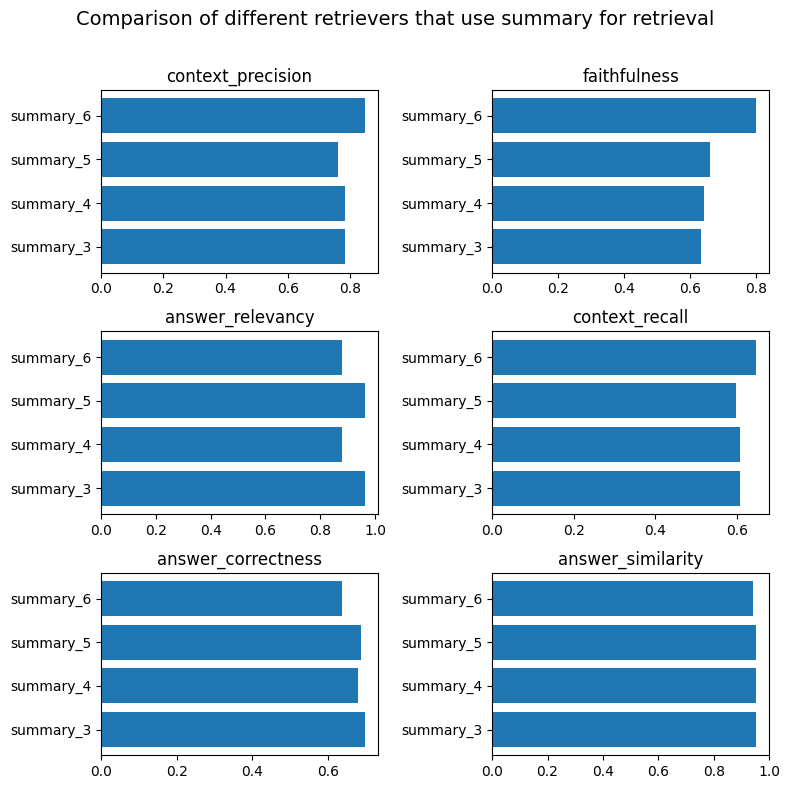

In [104]:
fig, ax = plt.subplots(3, 2, figsize=(8,8))
fig.suptitle('Comparison of different retrievers that use summary for retrieval', fontsize=14)
for i, metric in enumerate(metrics):
  metric_data = {}
  for name, val in summary_qa_results.items():
    metric_data[name] = val[metric]


  names = list(metric_data.keys())
  values = list(metric_data.values())

  ax[i//2][i%2].barh(range(len(metric_data)), values, tick_label=names)
  ax[i//2][i%2].set_title(f'{metric}')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show();

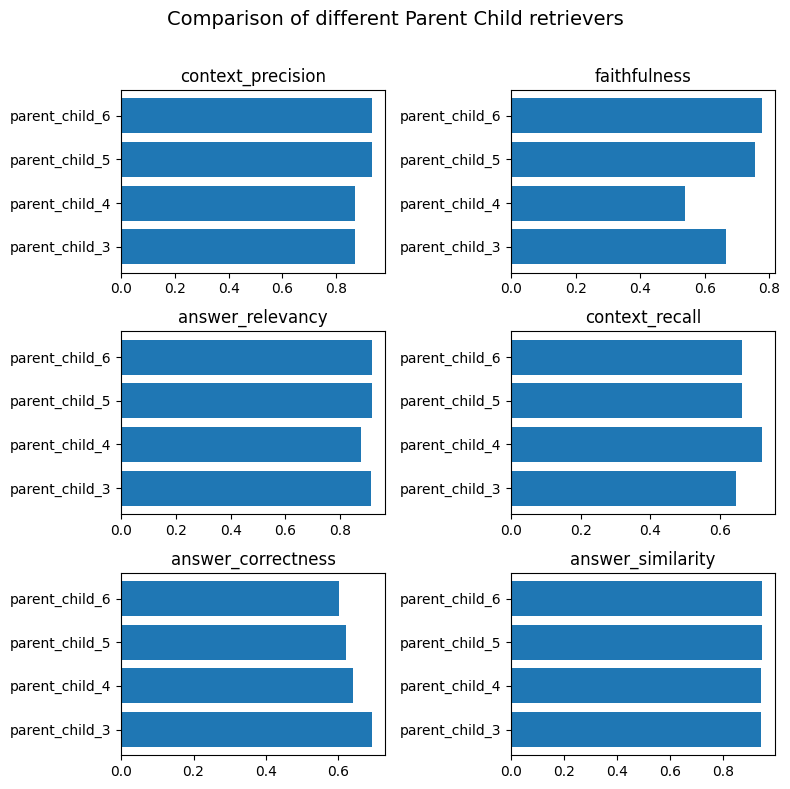

In [108]:
fig, ax = plt.subplots(3, 2, figsize=(8,8))
fig.suptitle('Comparison of different Parent Child retrievers', fontsize=14)
for i, metric in enumerate(metrics):
  metric_data = {}
  for name, val in parent_child_qa_results.items():
    metric_data[name] = val[metric]


  names = list(metric_data.keys())
  values = list(metric_data.values())

  ax[i//2][i%2].barh(range(len(metric_data)), values, tick_label=names)
  ax[i//2][i%2].set_title(f'{metric}')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show();

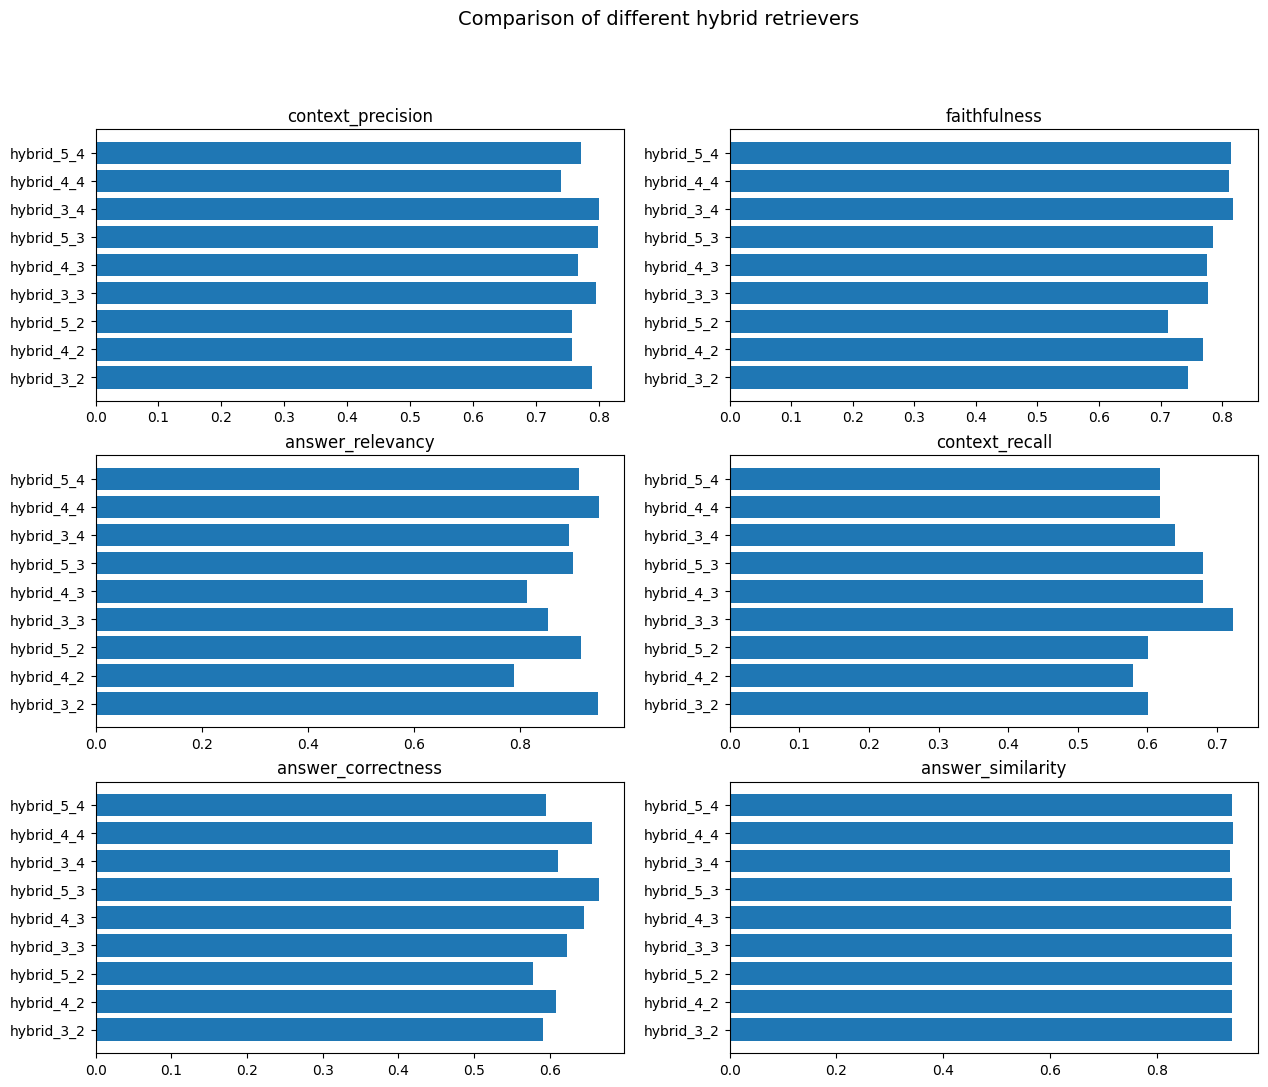

In [107]:
fig, ax = plt.subplots(3, 2, figsize=(15,12))
# fig.suptitle('Comparison of different hybrid retrievers', fontsize=16)
for i, metric in enumerate(metrics):
  metric_data = {}
  for name, val in hybrid_qa_results.items():
    metric_data[name] = val[metric]


  names = list(metric_data.keys())
  values = list(metric_data.values())

  ax[i//2][i%2].barh(range(len(metric_data)), values, tick_label=names)
  ax[i//2][i%2].set_title(f'{metric}')
# fig.tight_layout()
# fig.subplots_adjust(top=0.88)
plt.suptitle("Comparison of different hybrid retrievers", fontsize=14)
plt.show();

In [131]:
final_qa_chains = [summary_qa_3_chain, summary_qa_6_chain, parent_child_qa_6_chain, hybrid_qa_3_4_chain, hybrid_qa_4_4_chain]
final_qa_names = ['summary_3', 'summary_6', 'parent_child_6', 'hybrid_3_4', 'hybrid_4_4']

final_metrics = {'summary_3': summary_qa_results['summary_3'], 'summary_6': summary_qa_results['summary_6'], 'parent_child_6': parent_child_qa_results['parent_child_6'],
                 'hybrid_3_4': hybrid_qa_results['hybrid_3_4'], 'hybrid_4_4': hybrid_qa_results['hybrid_4_4']}

In [132]:
final_metrics

{'summary_3': {'context_precision': 0.7826, 'faithfulness': 0.6335, 'answer_relevancy': 0.9629, 'context_recall': 0.6087, 'answer_correctness': 0.6971, 'answer_similarity': 0.9528},
 'summary_6': {'context_precision': 0.8478, 'faithfulness': 0.7992, 'answer_relevancy': 0.8775, 'context_recall': 0.6467, 'answer_correctness': 0.6363, 'answer_similarity': 0.9436},
 'parent_child_6': {'context_precision': 0.9348, 'faithfulness': 0.7775, 'answer_relevancy': 0.9173, 'context_recall': 0.6630, 'answer_correctness': 0.6022, 'answer_similarity': 0.9492},
 'hybrid_3_4': {'context_precision': 0.8002, 'faithfulness': 0.8176, 'answer_relevancy': 0.8940, 'context_recall': 0.6395, 'answer_correctness': 0.6115, 'answer_similarity': 0.9375},
 'hybrid_4_4': {'context_precision': 0.7408, 'faithfulness': 0.8107, 'answer_relevancy': 0.9494, 'context_recall': 0.6178, 'answer_correctness': 0.6563, 'answer_similarity': 0.9425}}

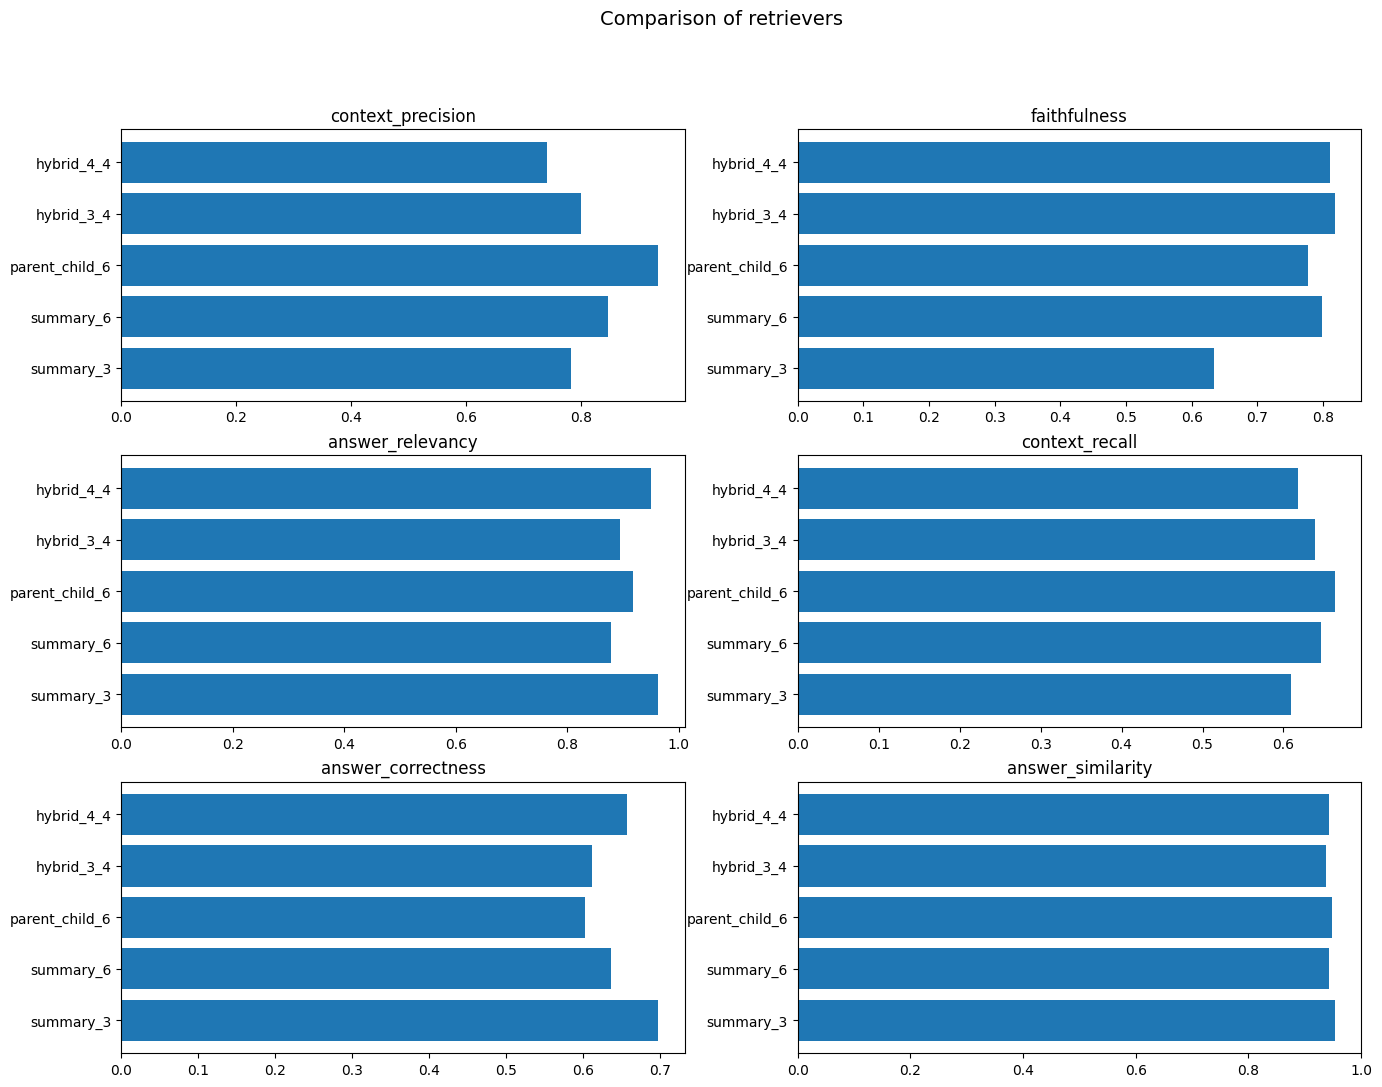

In [121]:
fig, ax = plt.subplots(3, 2, figsize=(16,12))
# fig.suptitle('Comparison of different hybrid retrievers', fontsize=16)
for i, metric in enumerate(metrics):
  metric_data = {}
  for name, val in final_metrics.items():
    metric_data[name] = val[metric]


  names = list(metric_data.keys())
  values = list(metric_data.values())

  ax[i//2][i%2].barh(range(len(metric_data)), values, tick_label=names)
  ax[i//2][i%2].set_title(f'{metric}')
# fig.tight_layout()
# fig.subplots_adjust(top=0.88)
plt.suptitle("Comparison of retrievers", fontsize=14)
plt.show();